In [1]:
import torch
print(torch.__version__)

1.13.0


## Обучение нейросети

In [2]:
# Часто нейросеть состоит из множества похожих/типовых кусков - мы их называем слои

# Чтобы не писать вручную каждое преобразование существует принятая практика - оборачивать слои в специального
#  вида классы, позволяющие упростить, ускорить и оптимизировать работу с нейросетью

# Ниже приведён пример того, как можно создать соответствующий класс для линейного слоя нейросети

# torch.nn.Module - специальный класс в PyTorch. Всегда наследуйте свои классы слоёв от него, это позволит вам
#  сильно меньше всего вручную прописывать и даст множество преимуществ
class MyLinear(torch.nn.Module):
    # Вам нужно переопределить 2 функции внутри класса
    #  1. __init__() --> эта функция отвечает за инициализацию слоя, передавайте в неё все параметры, необходимые
    #                    для того чтобы понять сколько и каких весов будет у слоя, как их проинициализировать и т.д.
    def __init__(
        self,
        in_features,  # Число параметров на входе в слой
        out_features,  # Число параметров на выходе из слоя
    ):
        super().__init__()  # Специальная функция для отнаследованных классов, всегда пишите в начале __init__
        # Задаём через nn.Parameter, чтобы torch знал, что это обучаемые веса модуля
        self.weight = torch.nn.Parameter(torch.randn(in_features, out_features))  # Матрица весов
        self.bias = torch.nn.Parameter(torch.zeros(out_features))  # Вектор смещения

    #  2. forward() --> эта функция отвечает за прямой проход через слой нейросети
    #                   (получает на вход данные, выдаёт преобразованные данные)
    def forward(self, input):
        return (input @ self.weight) + self.bias

In [3]:
# Многие слои уже присутствуют в PyTorch и их классы находятся в torch.nn
# К примеру - линейный слой
linear_layer = torch.nn.Linear(2, 3)

x = torch.rand(2)

linear_layer(x)

tensor([-0.1064, -0.3274, -0.6193], grad_fn=<AddBackward0>)

In [4]:
# Перепишем шаг обучения как раньше, но с обновлениями
n = 5  # Сколько переменных получаем на вход
k = 2  # Сколько переменных предсказываем

batch_size = 10  # Размер батча - по скольким примерам за раз считаем градиенты

# Данные и таргет для задачи классификации на k классов
x = torch.rand(batch_size, n)  # матрица размера (batch_size x n)
y_true = torch.randint(4, size=(k,))  # вектор размера (k)

# Давайте будем использовать двухслойную нейросеть
#  x > Линейный слой 1 > Функция активации 1 > Линейный слой 2 > Softmax (т.к. задача классификации)
hidden_size = 5  # Размер скрытого слоя
lin1 = torch.nn.Linear(n, hidden_size)
act1 = torch.nn.Tanh()
lin2 = torch.nn.Linear(hidden_size, k)
log_softmax = torch.nn.LogSoftmax(dim=1)  # dim указывает вдоль какого измерения мы применяем softmax

# Полностью наше преобразование будет иметь вид:
y_pred = log_softmax(lin2(act1(lin1(x))))  # согласитесь, не очень удобно и красиво

# Можно записать поэтапно (к примеру внутри forward функции слоя так часто удобно)
h = act1(lin1(x))  # матрица размера (batch_size x hidden_size)
y_pred = log_softmax(lin2(h))  # матрица размера (batch_size x k)

# Но так не всегда удобно писать в каждом месте где мы хотим применить модель, поэтому есть
#  специальная обёртка torch.nn.Sequential(), позволяющая превратить серию слоёв в один слой,
#  применяющий все слои один за другим, как мы и писали ранее
model = torch.nn.Sequential(
    lin1,
    act1,
    lin2,
    log_softmax,
)

model(x)

tensor([[-0.7680, -0.6235],
        [-0.7922, -0.6031],
        [-0.6898, -0.6965],
        [-0.7034, -0.6830],
        [-0.7091, -0.6774],
        [-0.7013, -0.6850],
        [-0.7881, -0.6064],
        [-0.8288, -0.5737],
        [-0.8494, -0.5581],
        [-0.8466, -0.5602]], grad_fn=<LogSoftmaxBackward0>)

In [ ]:
model

In [6]:
# Можно ещё задавать очень красиво Sequential так, чтобы подписи в описании модели были более понятными
from collections import OrderedDict

model = torch.nn.Sequential(
    OrderedDict([
        ("linear_1", torch.nn.Linear(n, hidden_size)),
        ("activation_1", torch.nn.Tanh()),
        ("linear_2", torch.nn.Linear(hidden_size, k)),
        ("log_softmax", torch.nn.LogSoftmax(dim=1)),
    ])
)

model

Sequential(
  (linear_1): Linear(in_features=5, out_features=5, bias=True)
  (activation_1): Tanh()
  (linear_2): Linear(in_features=5, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

In [7]:
# Попробуем на конкретных данных
from sklearn.datasets import make_classification

# Создадим датасет для классификации
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_classes=2,
    
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

X.shape, y.shape  # 1000 примеров, 2 фичи, предсказываем класификацию на 2 класса

(torch.Size([1000, 2]), torch.Size([1000]))

In [8]:
# 2 класса
y.min(), y.max()

(tensor(0), tensor(1))

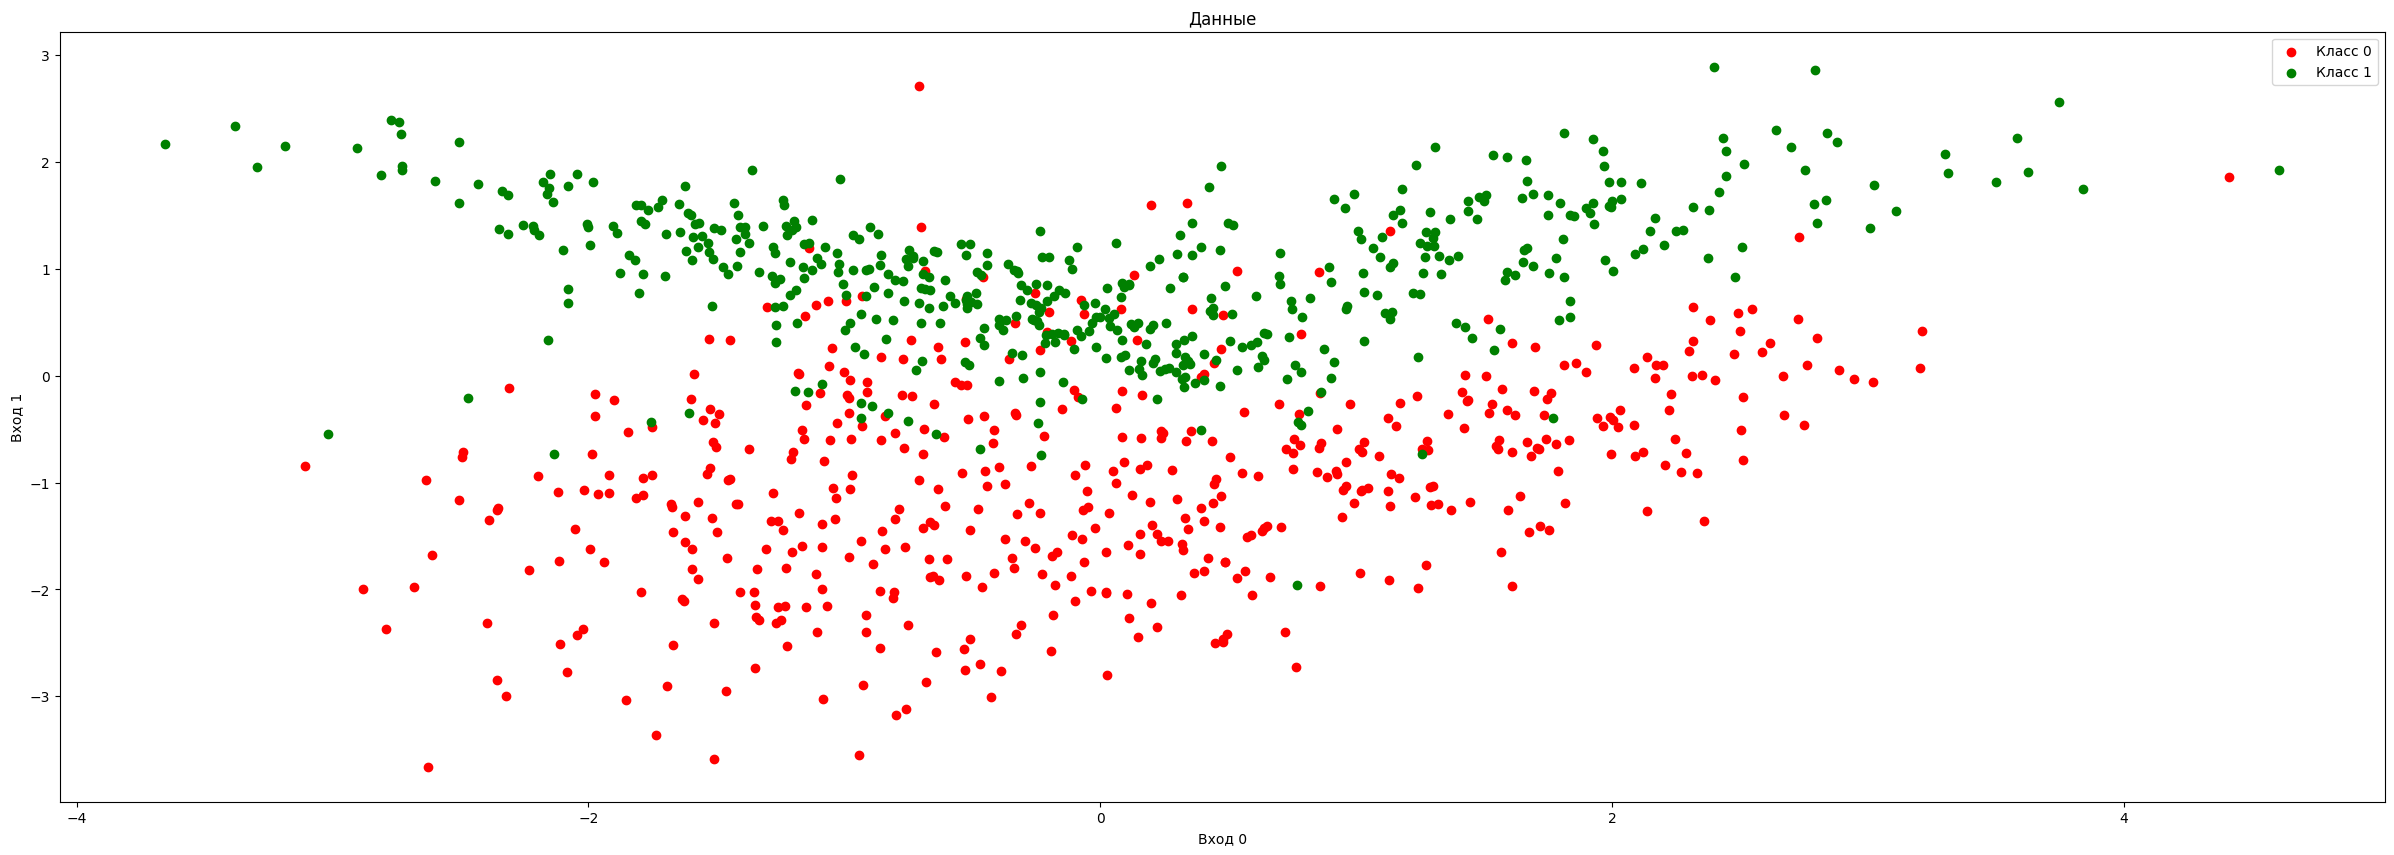

In [9]:
# Визуализируем данные
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

fig, ax = plt.subplots(figsize=(30, 10))
colors = ["red", "green"]
for target in range(2):
    plt.scatter(X[y == target, 0], X[y == target, 1], label=f"Класс {target}", c=colors[target])

plt.title("Данные")
plt.xlabel("Вход 0")
plt.ylabel("Вход 1")
plt.legend()
plt.show()

In [10]:
# Делаем сетку точек на плоскости, чтобы потом проверять предсказания нашей модели
xy_min, xy_max = -4, 4
grid_size = 120
grid = torch.linspace(xy_min, xy_max, grid_size, dtype=torch.float32)
grid_x_1, grid_x_2 = torch.meshgrid(grid, grid, indexing='ij')

grid = torch.stack([grid_x_1.reshape(-1), grid_x_2.reshape(-1)], dim=1)
print(grid.shape, grid.dtype)

torch.Size([14400, 2]) torch.float32


In [11]:
# Обучим простую двухслойную нейросеть на задачу классификации
model = torch.nn.Sequential(
    OrderedDict([
        ("linear_1", torch.nn.Linear(2, 4)),
        ("activation_1", torch.nn.ReLU()),
        ("linear_2", torch.nn.Linear(4, 2)),
        ("log_softmax", torch.nn.LogSoftmax(dim=1)),
    ])
)

model

Sequential(
  (linear_1): Linear(in_features=2, out_features=4, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=4, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

In [12]:
# Оптимайзеры
optimizer = torch.optim.SGD(
    model.parameters(),  # Передаём все тензоры, учавствующие в градиентном спуске
    lr=1.,  # learning rate - величина шага градиентного спуска
)

# Две основные функции для оптимайзера:
#  1. optimizer.step() --> сделать шаг оптимизации 
#      (т.е. применить w -= lr * w.grad в случае простого SGD для всех тензоров, учавствующих в обучении)
#  2. optimizer.zero_grad() --> обнулить все градиенты
#      (т.е. применить w.grad.zero_() для всех тензоров, учавствующих в обучении)

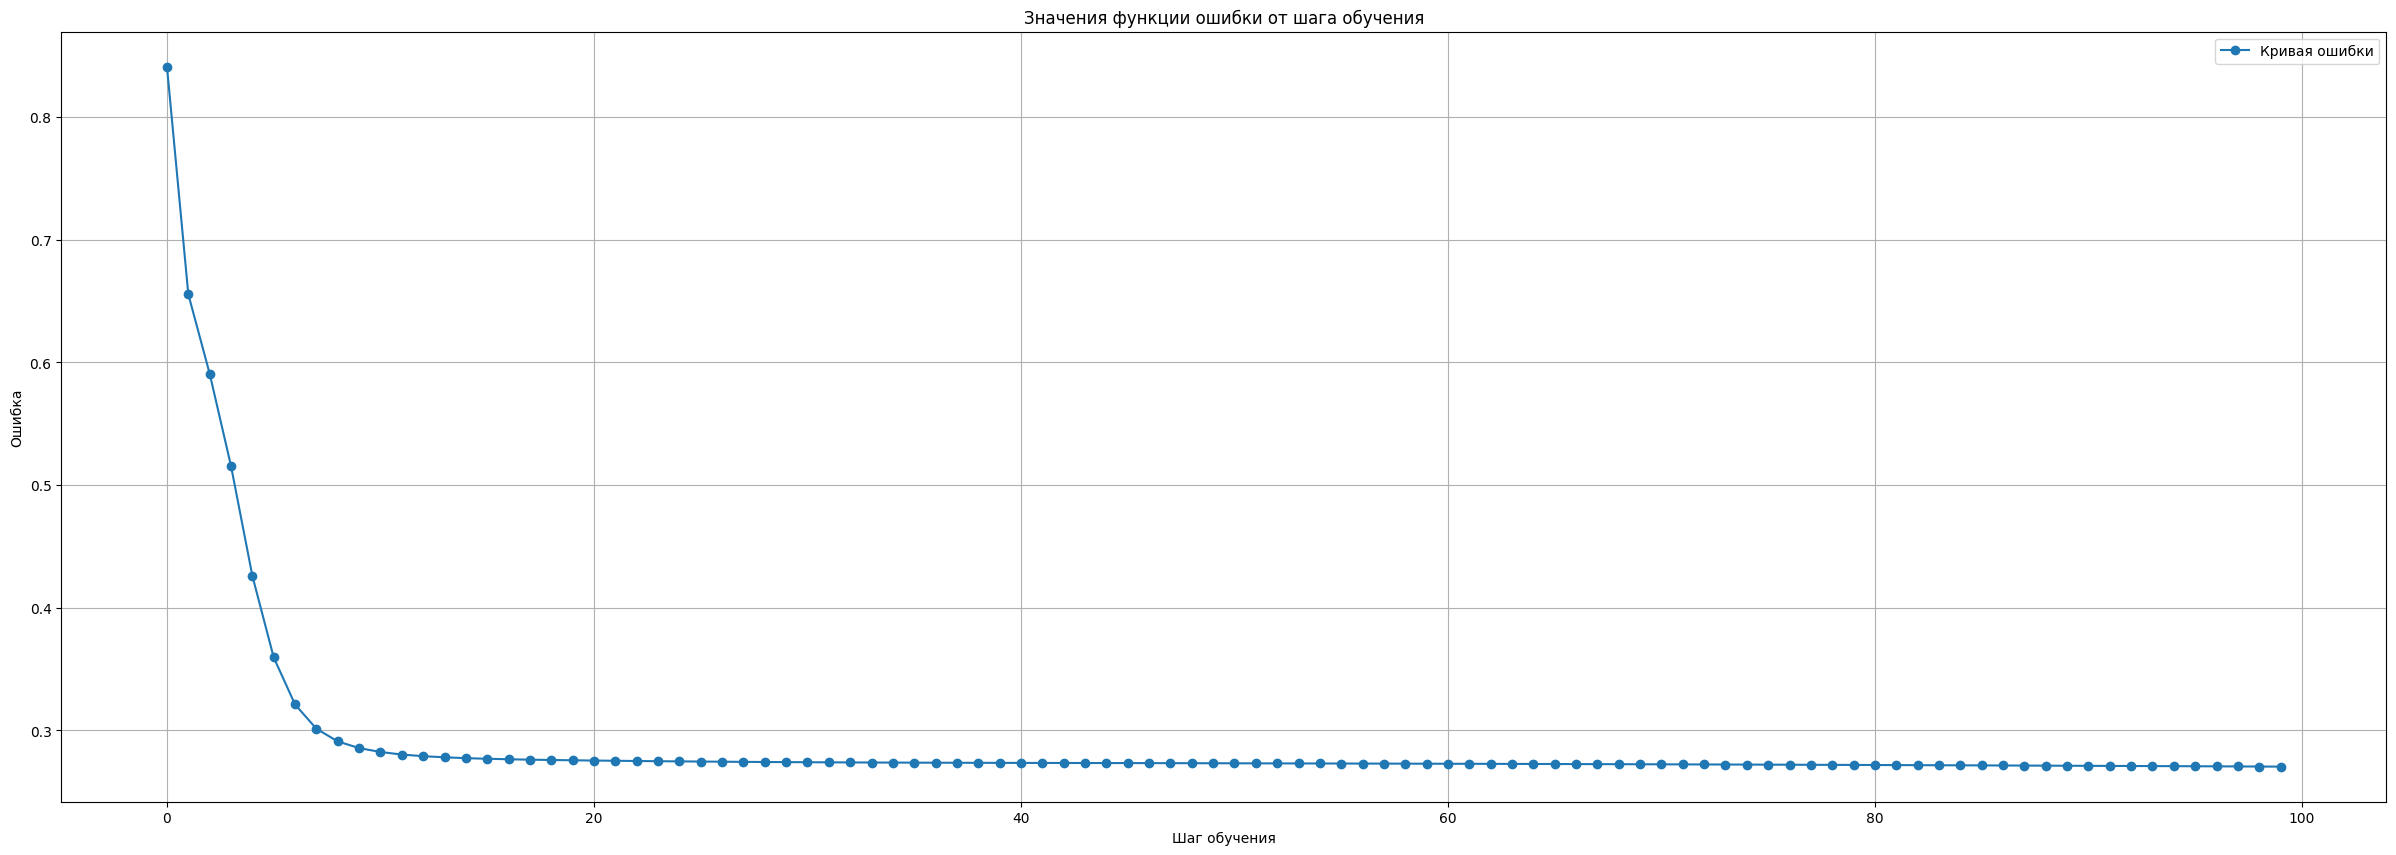

In [13]:
losses = []  # Будем собирать информацию об ошибке по ходу обучения для визуализации
grid_preds = []  # Так же будем собирать информацию о предсказаниях модели на сетке

loss_fn = torch.nn.NLLLoss()  # Используем NLLLoss, т.к. задача классификации и мы предсказываем лог-вероятности классов

for step in range(1, 101):
    optimizer.zero_grad()  # Обнуляем градиенты
    y_pred = model(X)  # Считаем forward шаг на всех данных
    loss = loss_fn(y_pred, y)  # Считаем величину ошибки
    
    # Записываем значение ошибки в список, чтобы позже визуализировать
    #  (.item() возвращает само значение вместо тензора)
    losses.append(loss.item())
    
    loss.backward()  # Считаем градиенты для всех задейстованных тензоров
    optimizer.step()  # Делаем шаг градиентного спуска
    
    with torch.no_grad():  # Используем обёртку, т.к. нам не требуются градиенты на наших тестовых предсказаниях
        grid_preds.append(model(grid))
    

# Визуализируем как менялось значение ошибки на данных
fig, ax = plt.subplots(figsize=(30, 10))
plt.plot(losses, "o-", label="Кривая ошибки")

plt.title("Значения функции ошибки от шага обучения")
plt.xlabel("Шаг обучения")
plt.ylabel("Ошибка")
plt.grid()
plt.legend()
plt.show()

In [14]:
# Посмотрим как выглядят предсказания нашей модели на сетке на последнем шаге
pred_class_probs = grid_preds[-1].exp()  # Получаем вероятности классов на последнем шаге обучения для каждой точки сетки
print(f"Предсказанные вероятности классов:\n{pred_class_probs}\n")

pred_class = 1 * (pred_class_probs[:, 1] > 0.5)  # Предсказанные классы - умножаем на 1, чтобы получить int вместо bool
print(f"Предсказанные классы:\n{pred_class}")

Предсказанные вероятности классов:
tensor([[9.9990e-01, 9.6343e-05],
        [9.9989e-01, 1.1385e-04],
        [9.9987e-01, 1.3454e-04],
        ...,
        [4.5809e-03, 9.9542e-01],
        [4.1831e-03, 9.9582e-01],
        [3.8197e-03, 9.9618e-01]])

Предсказанные классы:
tensor([0, 0, 0,  ..., 1, 1, 1])


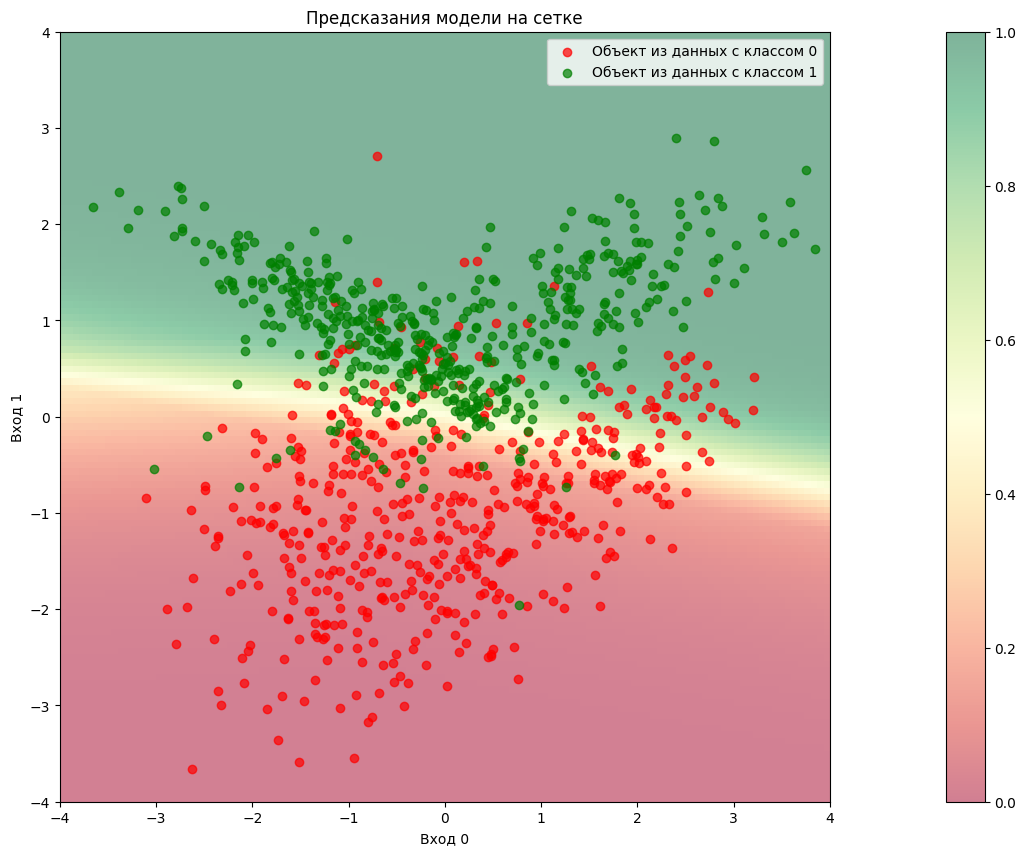

In [15]:
# Рисуем
fig, ax = plt.subplots(figsize=(30, 10))
colors = ["red", "green"]
for target in range(2):
    plt.scatter(
        X[y == target, 0],
        X[y == target, 1],
        marker="o",
        label=f"Объект из данных с классом {target}",
        c=colors[target],
        alpha=0.7,
    )
    
plt.imshow(
    pred_class_probs[:, 0].reshape(grid_size, grid_size).T,
    vmin=0.,
    vmax=1.,
    cmap=mpl.colormaps["RdYlGn"],
    extent=(xy_min, xy_max, xy_min, xy_max),
    alpha=0.5,
)

plt.title("Предсказания модели на сетке")
plt.xlabel("Вход 0")
plt.ylabel("Вход 1")
plt.legend()
plt.colorbar()
plt.show()

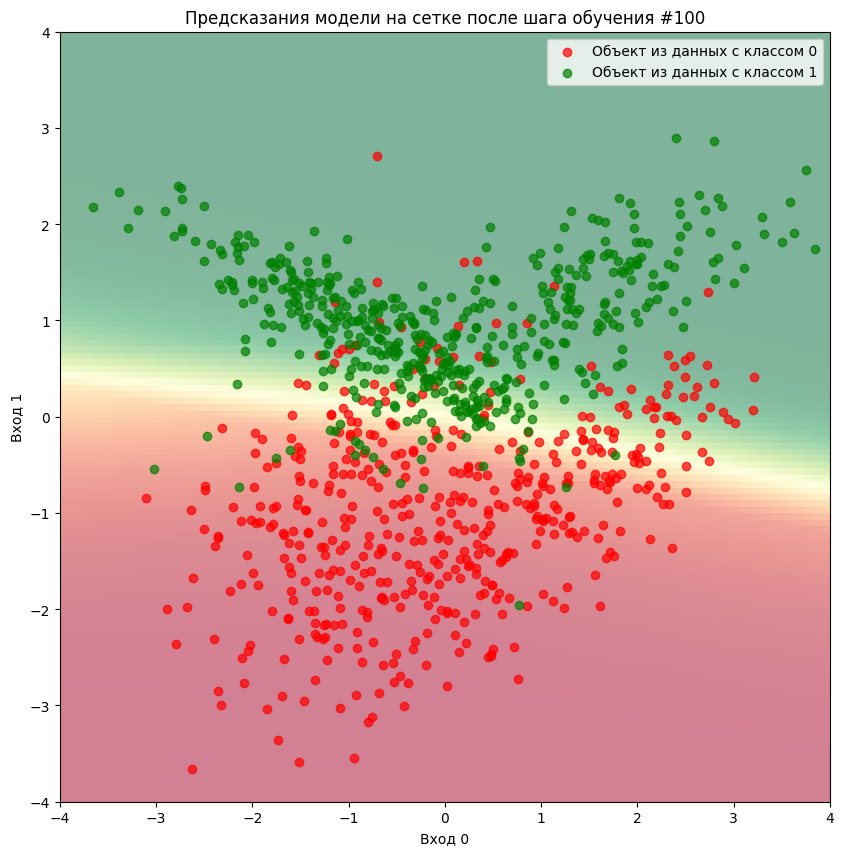

In [16]:
# Анимация того как училась модель
from time import sleep
from IPython.display import clear_output

draw_x0s = []
draw_x1s = []
draw_y0s = []
draw_y1s = []
all_pred_class_probs = []

# Предпосчитываем для скорости анимации
for i in range(100):
    pred_class_probs = grid_preds[i].exp()
    
    draw_x0s.append(X[y == 0, 0])
    draw_x1s.append(X[y == 1, 0])
    
    draw_y0s.append(X[y == 0, 1])
    draw_y1s.append(X[y == 1, 1])
    
    all_pred_class_probs.append(pred_class_probs[:, 0].reshape(grid_size, grid_size).T)

# Рисуем
for i in range(100):
    clear_output(True)
    
    fig, ax = plt.subplots(figsize=(30, 10))
    for xs, ys, meta in [
        (draw_x0s, draw_y0s, ("o", f"Объект из данных с классом 0", "red")),
        (draw_x1s, draw_y1s, ("o", f"Объект из данных с классом 1", "green")),
    ]:
        plt.scatter(
            xs[i],
            ys[i],
            marker=meta[0],
            label=meta[1],
            c=meta[2],
            alpha=0.7,
        )
        
    plt.imshow(
    all_pred_class_probs[i],
        vmin=0.,
        vmax=1.,
        cmap=mpl.colormaps["RdYlGn"],
        extent=(xy_min, xy_max, xy_min, xy_max),
        alpha=0.5,
    )

    plt.title(f"Предсказания модели на сетке после шага обучения #{i+1}")
    plt.xlabel("Вход 0")
    plt.ylabel("Вход 1")
    plt.legend()
    plt.show()
    
#     sleep(0.2)